# Global

In [1]:
model_saved_name="model_colab.ckpt"
dataset_path=r"data\std_dataset"

# path using \ instead of /

## processing...

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import NW_LSTM
import NN_DataLoader

# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cpu")
print("Device using ", device)

# Instantiate the model with appropriate dimensions
model = NW_LSTM.get_global_model().to(device)

# load model from ckpt file
model.load_state_dict(torch.load(model_saved_name, map_location=device))


class MyDataset(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]



Device using  cpu


Data size  7400
model parameters:  90653


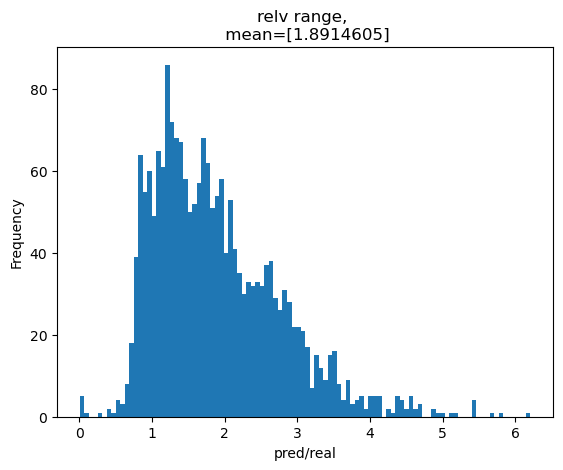

C:\Users\AR THUR\AppData\Local\Temp\ipykernel_23040\1577170469.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(error_95[0]), float(error_95[1])) +


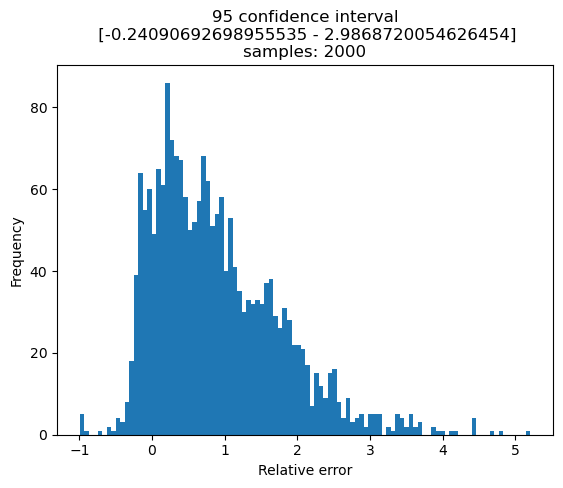

[[1029865.6875    458871.15625 ]
 [ 867099.5625    264502.5625  ]
 [ 156112.25      161120.609375]
 [ 355493.75      194033.046875]]


In [3]:
import Maglib

# magData = Maglib.MagLoader(dataset_path+r"\test.mat")
magData = Maglib.MagLoader(dataset_path+r"\data_processed.mat")

x_data = np.zeros([magData.b.shape[0], magData.b.shape[1], 3])
x_data[:, :, 0] = magData.b
x_data[:, :, 1] = magData.freq
x_data[:, :, 2] = magData.temp

idx = 0
dataNums = magData.freq.shape[0]
# no more than 2000
if(dataNums>2000):dataNums=2000


x_data = x_data[idx:idx + dataNums, :, :]
y_data = magData.loss[idx:idx + dataNums, :]

# Now we can pass a batch of sequences through the model
inputs = torch.tensor(x_data, dtype=torch.float32)

outputs = model(inputs)

total_params = sum(p.numel() for p in model.parameters())

print('Data size ', magData.b.shape[0])
print('model parameters: ', total_params)

# get model performance

# get loss
pred = outputs.detach().numpy()
real = y_data

import linear_std

std_loss = linear_std.linear_std()
std_loss.load(dataset_path+r"\std_loss.stdd")

pred = std_loss.unstd(pred)
real = std_loss.unstd(real)

error = (pred - real) / real
error_mean = np.mean(error, axis=0)
# calculate the 95% confidence interval
error_95 = list(
    [np.percentile(error, 2.5, axis=0),
     np.percentile(error, 97.5, axis=0)])

# calculate r square error
r_square= 1 - np.sum((pred - real)**2, axis=0) / np.sum((real - np.mean(real, axis=0))**2, axis=0)

# calculate relative value
relv = pred / real
mean_relv = np.mean(relv, axis=0)
relv_display=relv-mean_relv

plt.figure()
plt.title("relv range, \n mean="+str(mean_relv))
plt.hist(relv, bins=100)
plt.ylabel('Frequency')
plt.xlabel('pred/real')
plt.show()

data_display = np.zeros([4, 2])
data_display[:, 0] = pred[0:4, 0]
data_display[:, 1] = real[0:4, 0]

# plot the distribution of error
plt.figure()
plt.title("95 confidence interval\n [{} - {}]".format(
    float(error_95[0]), float(error_95[1])) +
    '\nsamples: ' + str(len(y_data)))
#plt.xlim(-0.5, 0.5)
plt.hist(error, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Relative error')
plt.show()

print(data_display)


material_name:  modelB
(7400, 128)
(7400, 1)
(7400, 1)
Device using  cpu


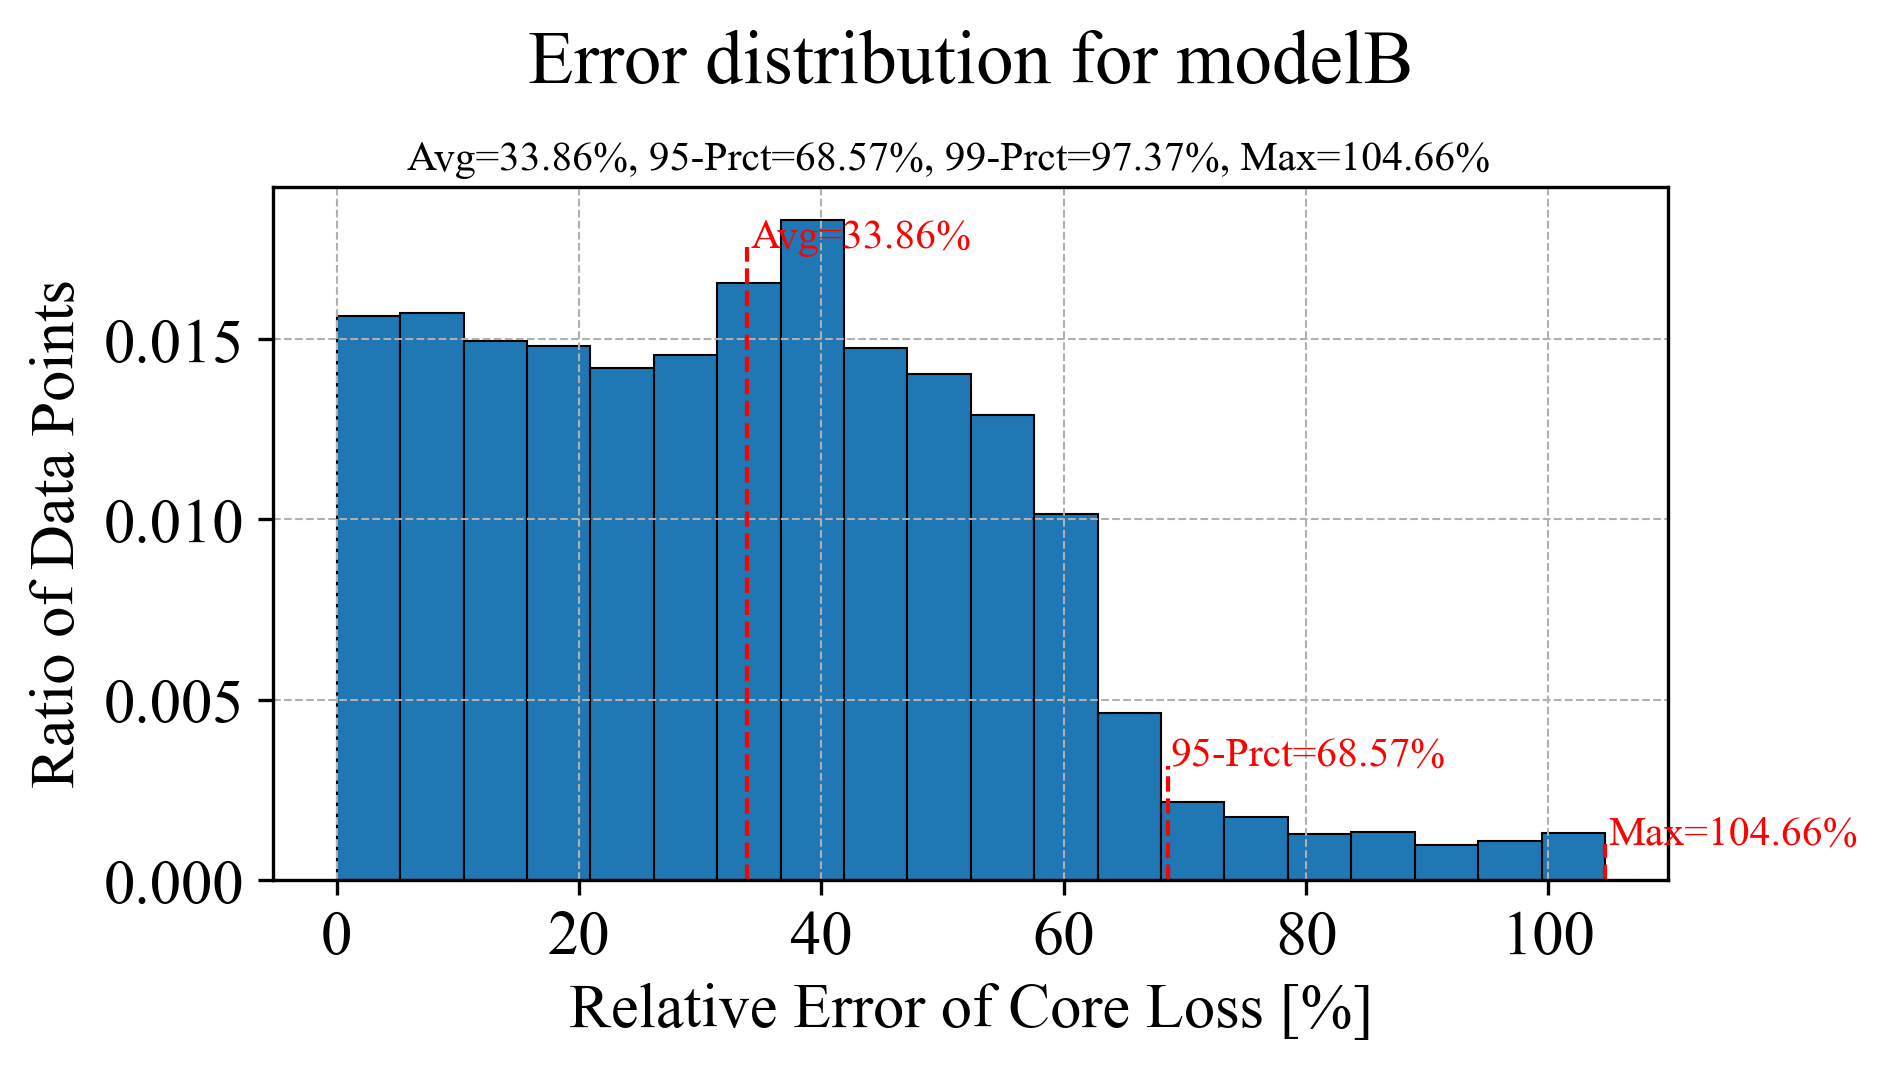

In [4]:
import MagNet

# get current folder name
import os
material_name = os.path.basename(os.getcwd())
material_name = material_name.split('_')[2]
print("material_name: ", material_name)


# csv_folder_path=r"G:\我的云端硬盘\DeepLearning\Challenge\Challange_Data"+('\\'+material_name)*2

# data_b = np.loadtxt(csv_folder_path+r'\B_waveform.csv', delimiter=',').astype(np.float32)
# data_temp = ((np.loadtxt(csv_folder_path+r'\Temperature.csv', delimiter=',') + 273.15).astype(np.float32))[:,np.newaxis]
# data_freq = (np.loadtxt(csv_folder_path+r'\Frequency.csv', delimiter=',').astype(np.float32))[:,np.newaxis]
# data_loss = np.loadtxt(csv_folder_path+r'\Volumetric_Loss.csv', delimiter=',').astype(np.float32)[:,np.newaxis]

std_loss = linear_std.linear_std()
std_loss.load(dataset_path+r"\std_loss.stdd")

std_temp = linear_std.linear_std()
std_temp.load(dataset_path+r"\std_temp.stdd")

std_freq = linear_std.linear_std()
std_freq.load(dataset_path+r"\std_freq.stdd")

std_b = linear_std.linear_std()
std_b.load(dataset_path+r"\std_b.stdd")


data_b = std_b.unstd(magData.b)
data_temp = std_temp.unstd(magData.temp)
data_freq = std_freq.unstd(magData.freq)
data_loss = std_loss.unstd(magData.loss)


print(data_b.shape)
print(data_temp.shape)
print(data_freq.shape)

B_waveform=0

pred_loss=MagNet.MagLoss(data_b,data_temp,data_freq)

data_loss=data_loss[:pred_loss.shape[0]]

pred_loss=pred_loss/mean_relv   # whether to use mean_relv or not
relv_err=np.abs(pred_loss-data_loss)/data_loss
# filter out the biggest 3% data
relv_err=np.sort(relv_err,axis=0)
relv_err=relv_err[:int(relv_err.shape[0]*0.98),:]

import os
save_path="G:\\我的云端硬盘\\DeepLearning\\Challenge\\plot\\plts\\"
MagNet.Mag_plot(material_name,relv_err,"",0)

In [5]:
if(0):
    bad_example=[]
    good_example=[]
    for idx in range(error.shape[0]):
        if abs(error[idx])>0.2:
            bad_example.append(idx)
        elif abs(error[idx])<0.04:
            good_example.append(idx)


    std_temp= linear_std.linear_std()
    std_temp.load(dataset_path+r"\std_temp.stdd")

    std_freq= linear_std.linear_std()
    std_freq.load(dataset_path+r"\std_freq.stdd")


    bad_freq=[]
    bad_temp=[]

    good_freq=[]
    good_temp=[]

    for idx in bad_example:
        bad_freq.append(std_freq.unstd(magData.freq[idx]))
        bad_temp.append(std_temp.unstd(magData.temp[idx]))

    for idx in good_example:
        good_freq.append(std_freq.unstd(magData.freq[idx]))
        good_temp.append(std_temp.unstd(magData.temp[idx]))


    # plot the distribution of good_freq vs bad_freq
    plt.figure()
    plt.title("error distribution in freq")
    plt.hist(np.array(good_freq),label="good")
    plt.hist(np.array(bad_freq),label="bad")
    plt.legend()
    plt.show()

    # plot the distribution of good_temp vs bad_temp
    plt.figure()
    plt.title("error distribution in temp")
    plt.hist(np.array(good_temp),label="good")
    plt.hist(np.array(bad_temp),label="bad")
    plt.legend()
    plt.show()

    # plot the distribution of error
    drawing=False

    if drawing:
        for idx in bad_example:
            plt.figure()
            # using title to show the temp and freq
            plt.title('temp: ' + str(std_temp.unstd(magData.temp[idx])) +
                    '\nfreq: ' + str(std_freq.unstd(magData.freq[idx])))

            plt.plot(magData.b[idx,:])
            plt.show()